In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
import pickle
import warnings
warnings.filterwarnings('ignore')

In [109]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/weather_data.csv')

In [110]:
print("Dataset Shape:", df.shape)
display(df.head())

Dataset Shape: (311, 7)


,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,Rain,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,Rain,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,Rain,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,Rain,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,Rain,38.062329,1030.264331


In [111]:
print("\nData types:")
display(df.dtypes)


Data types:


,0
date,object
avg_temperature,float64
humidity,float64
avg_wind_speed,float64
rain_or_not,object
cloud_cover,float64
pressure,float64


In [112]:
print("\nSummary statistics:")
display(df.describe())


Summary statistics:


,avg_temperature,humidity,avg_wind_speed,cloud_cover,pressure
count,296.000000,296.000000,296.000000,296.000000,311.000000
mean,25.983840,55.041385,7.556636,49.834827,1001.059119
std,6.802475,19.220133,5.344683,29.009459,28.835595
min,15.000000,30.000000,0.069480,0.321826,951.240404
25%,20.265692,34.280826,3.550354,24.530951,975.757545
50%,27.177958,56.759806,7.326421,50.725120,1001.938586
75%,32.204599,72.189837,11.050627,76.046506,1026.578884
max,35.000000,90.000000,56.636041,99.834751,1049.543752


In [113]:
print("\nMissing values count:")
display(df.isnull().sum())


Missing values count:


,0
date,0
avg_temperature,15
humidity,15
avg_wind_speed,15
rain_or_not,0
cloud_cover,15
pressure,0


In [114]:
def preprocess_data(df):
    # Create a copy of the dataframe
    data = df.copy()

    # Convert date column to datetime
    data['date'] = pd.to_datetime(data['date'])

    # Extract additional date features
    data['month'] = data['date'].dt.month
    data['day_of_week'] = data['date'].dt.dayofweek

    # Convert rain_or_not to binary (1 for Rain, 0 for No Rain)
    data['rain_binary'] = data['rain_or_not'].apply(lambda x: 1 if x == 'Rain' else 0)

    # Remove rows with missing values
    data = data.dropna()

    return data


In [115]:
clean_data = preprocess_data(df)
print("\nCleaned data shape:", clean_data.shape)
display(clean_data.head())


Cleaned data shape: (296, 10)


,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure,month,day_of_week,rain_binary
0,2023-01-01,23.745401,46.140905,7.845981,Rain,20.851051,992.965681,1,6,1
1,2023-01-02,30.030503,59.876587,5.382457,Rain,93.059521,1037.273025,1,0,1
2,2023-01-03,28.365224,51.464618,13.158008,Rain,11.636640,1034.193357,1,1,1
3,2023-01-04,27.550929,53.103799,5.886677,Rain,81.744971,968.610142,1,2,1
4,2023-01-05,23.639303,57.826186,12.248992,Rain,38.062329,1030.264331,1,3,1


In [116]:
print("\nRemaining missing values:")
display(clean_data.isnull().sum())


Remaining missing values:


,0
date,0
avg_temperature,0
humidity,0
avg_wind_speed,0
rain_or_not,0
cloud_cover,0
pressure,0
month,0
day_of_week,0
rain_binary,0


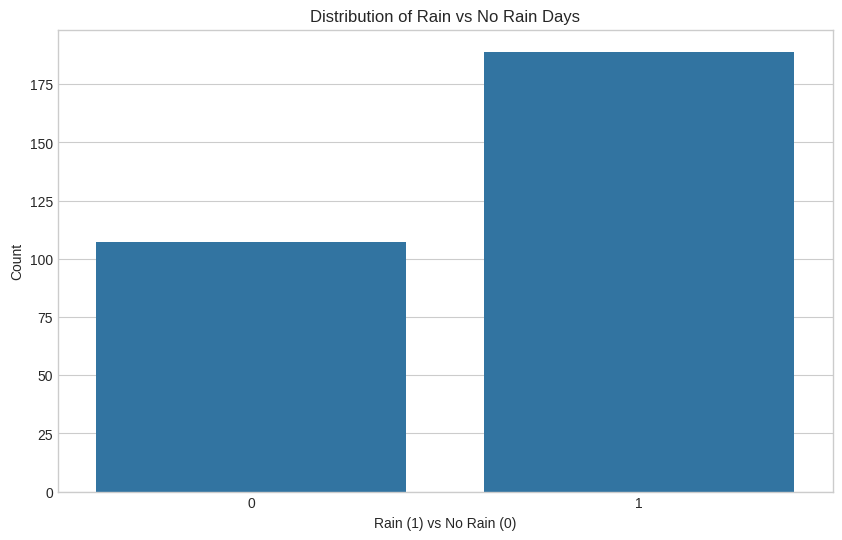

In [117]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

plt.figure(figsize=(10, 6))
sns.countplot(x='rain_binary', data=clean_data)
plt.title('Distribution of Rain vs No Rain Days')
plt.xlabel('Rain (1) vs No Rain (0)')
plt.ylabel('Count')
plt.show()


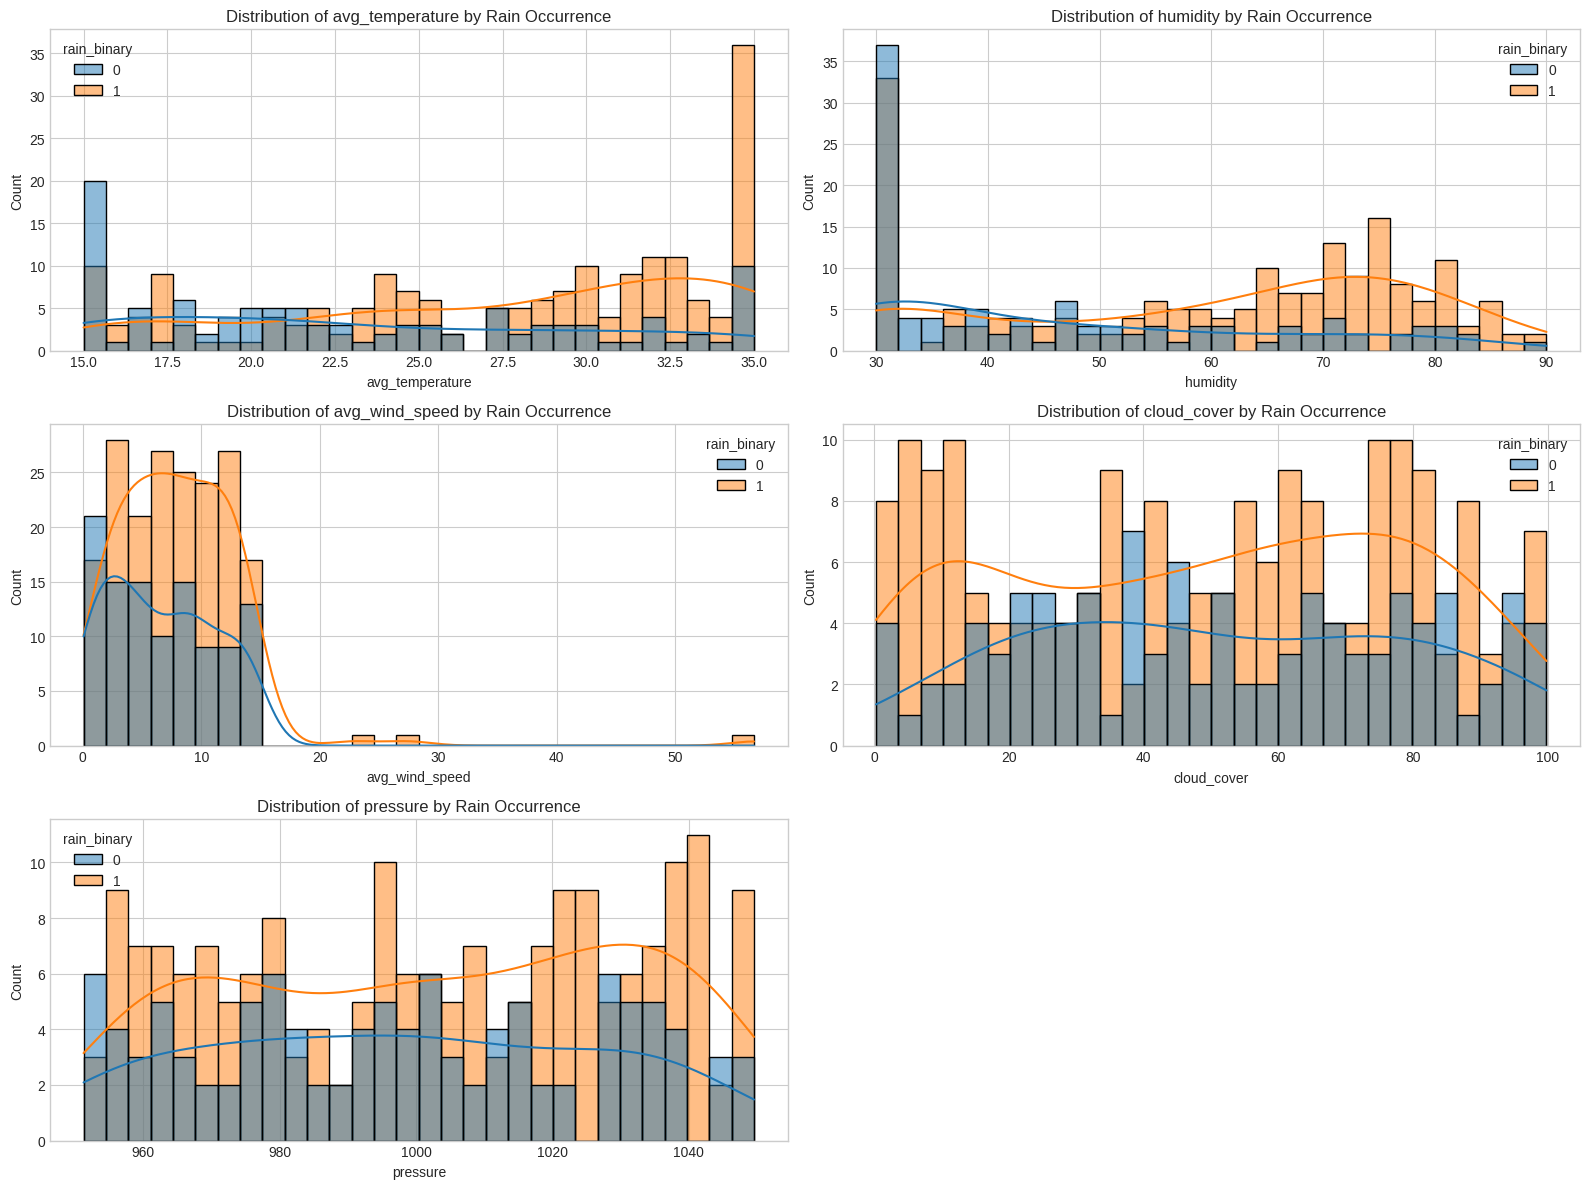

In [118]:
numerical_features = ['avg_temperature', 'humidity', 'avg_wind_speed']
if 'cloud_cover' in clean_data.columns:
    numerical_features.append('cloud_cover')
if 'pressure' in clean_data.columns:
    numerical_features.append('pressure')

plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 2, i+1)
    sns.histplot(data=clean_data, x=feature, hue='rain_binary', kde=True, bins=30)
    plt.title(f'Distribution of {feature} by Rain Occurrence')
plt.tight_layout()
plt.show()

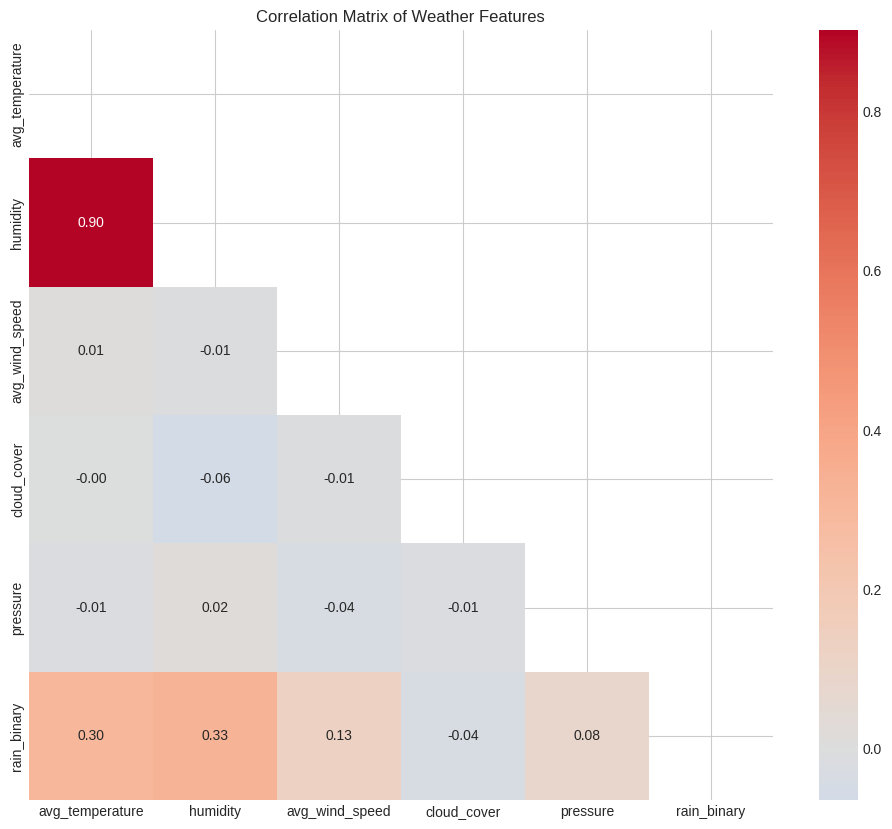

In [119]:
plt.figure(figsize=(12, 10))
feature_cols = numerical_features + ['rain_binary']
correlation = clean_data[feature_cols].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Weather Features')
plt.show()

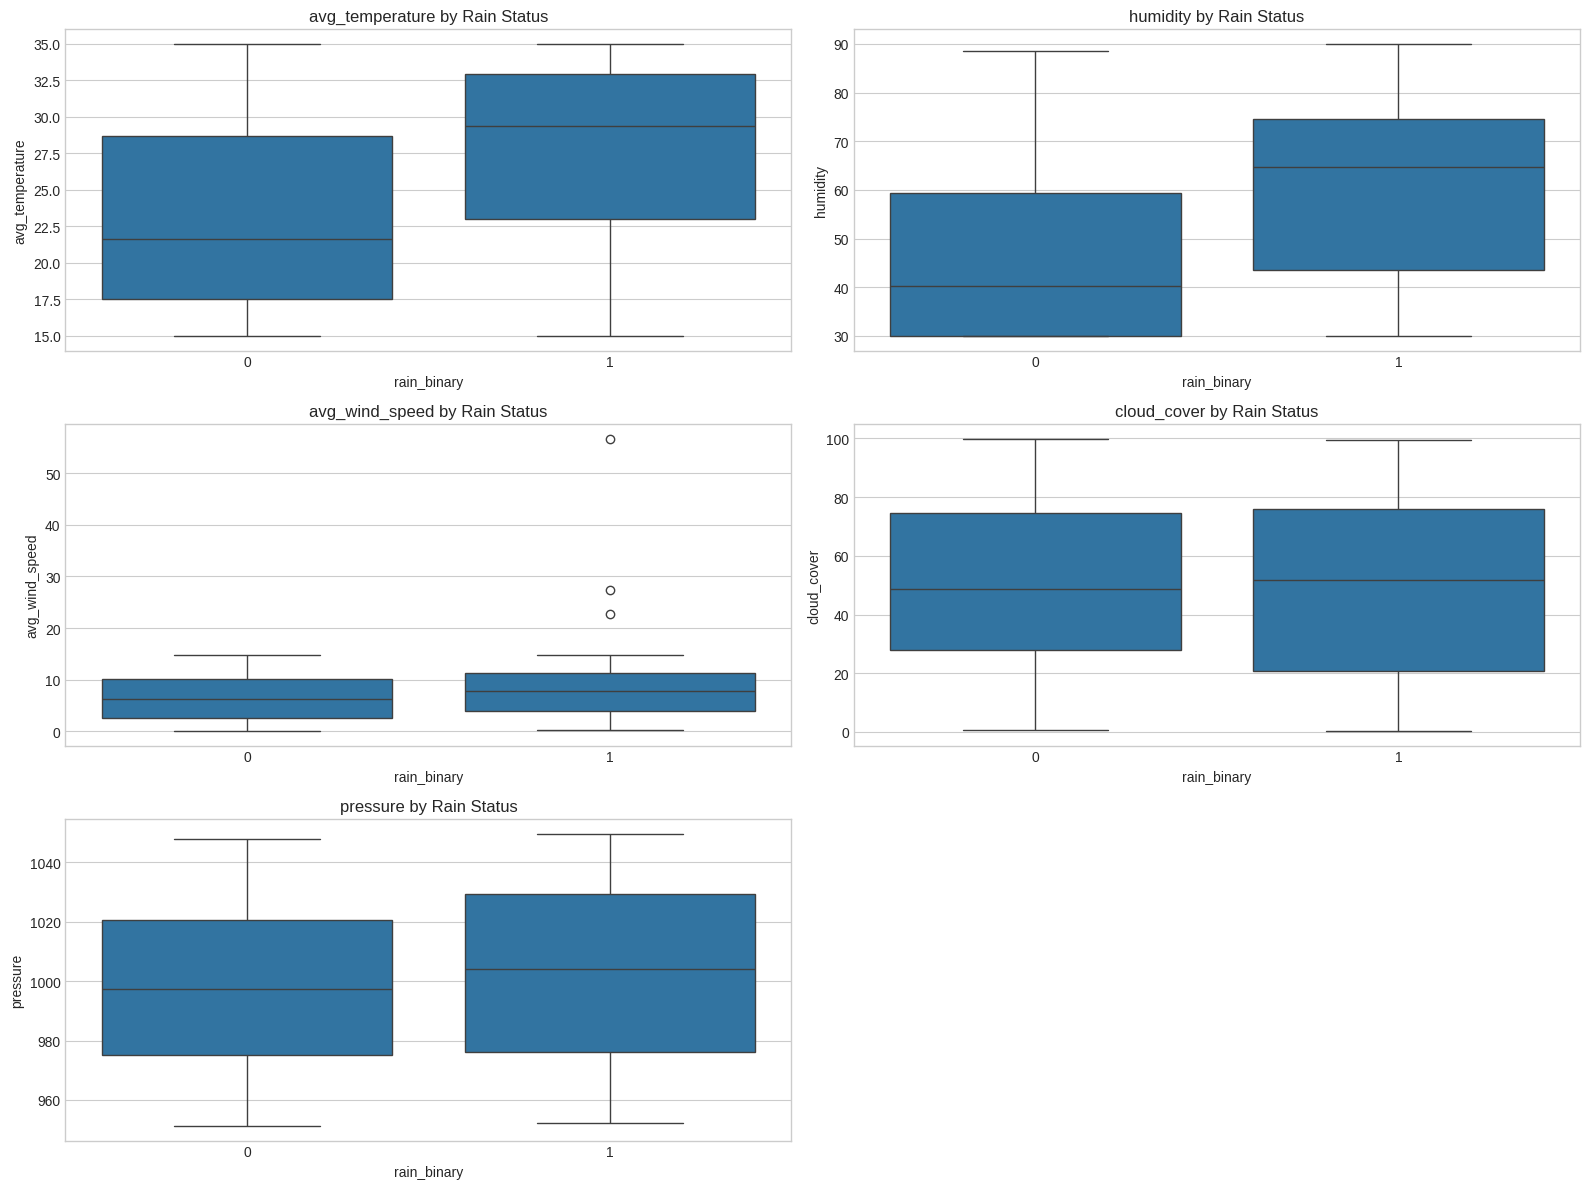

In [120]:
plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_features):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x='rain_binary', y=feature, data=clean_data)
    plt.title(f'{feature} by Rain Status')
plt.tight_layout()
plt.show()


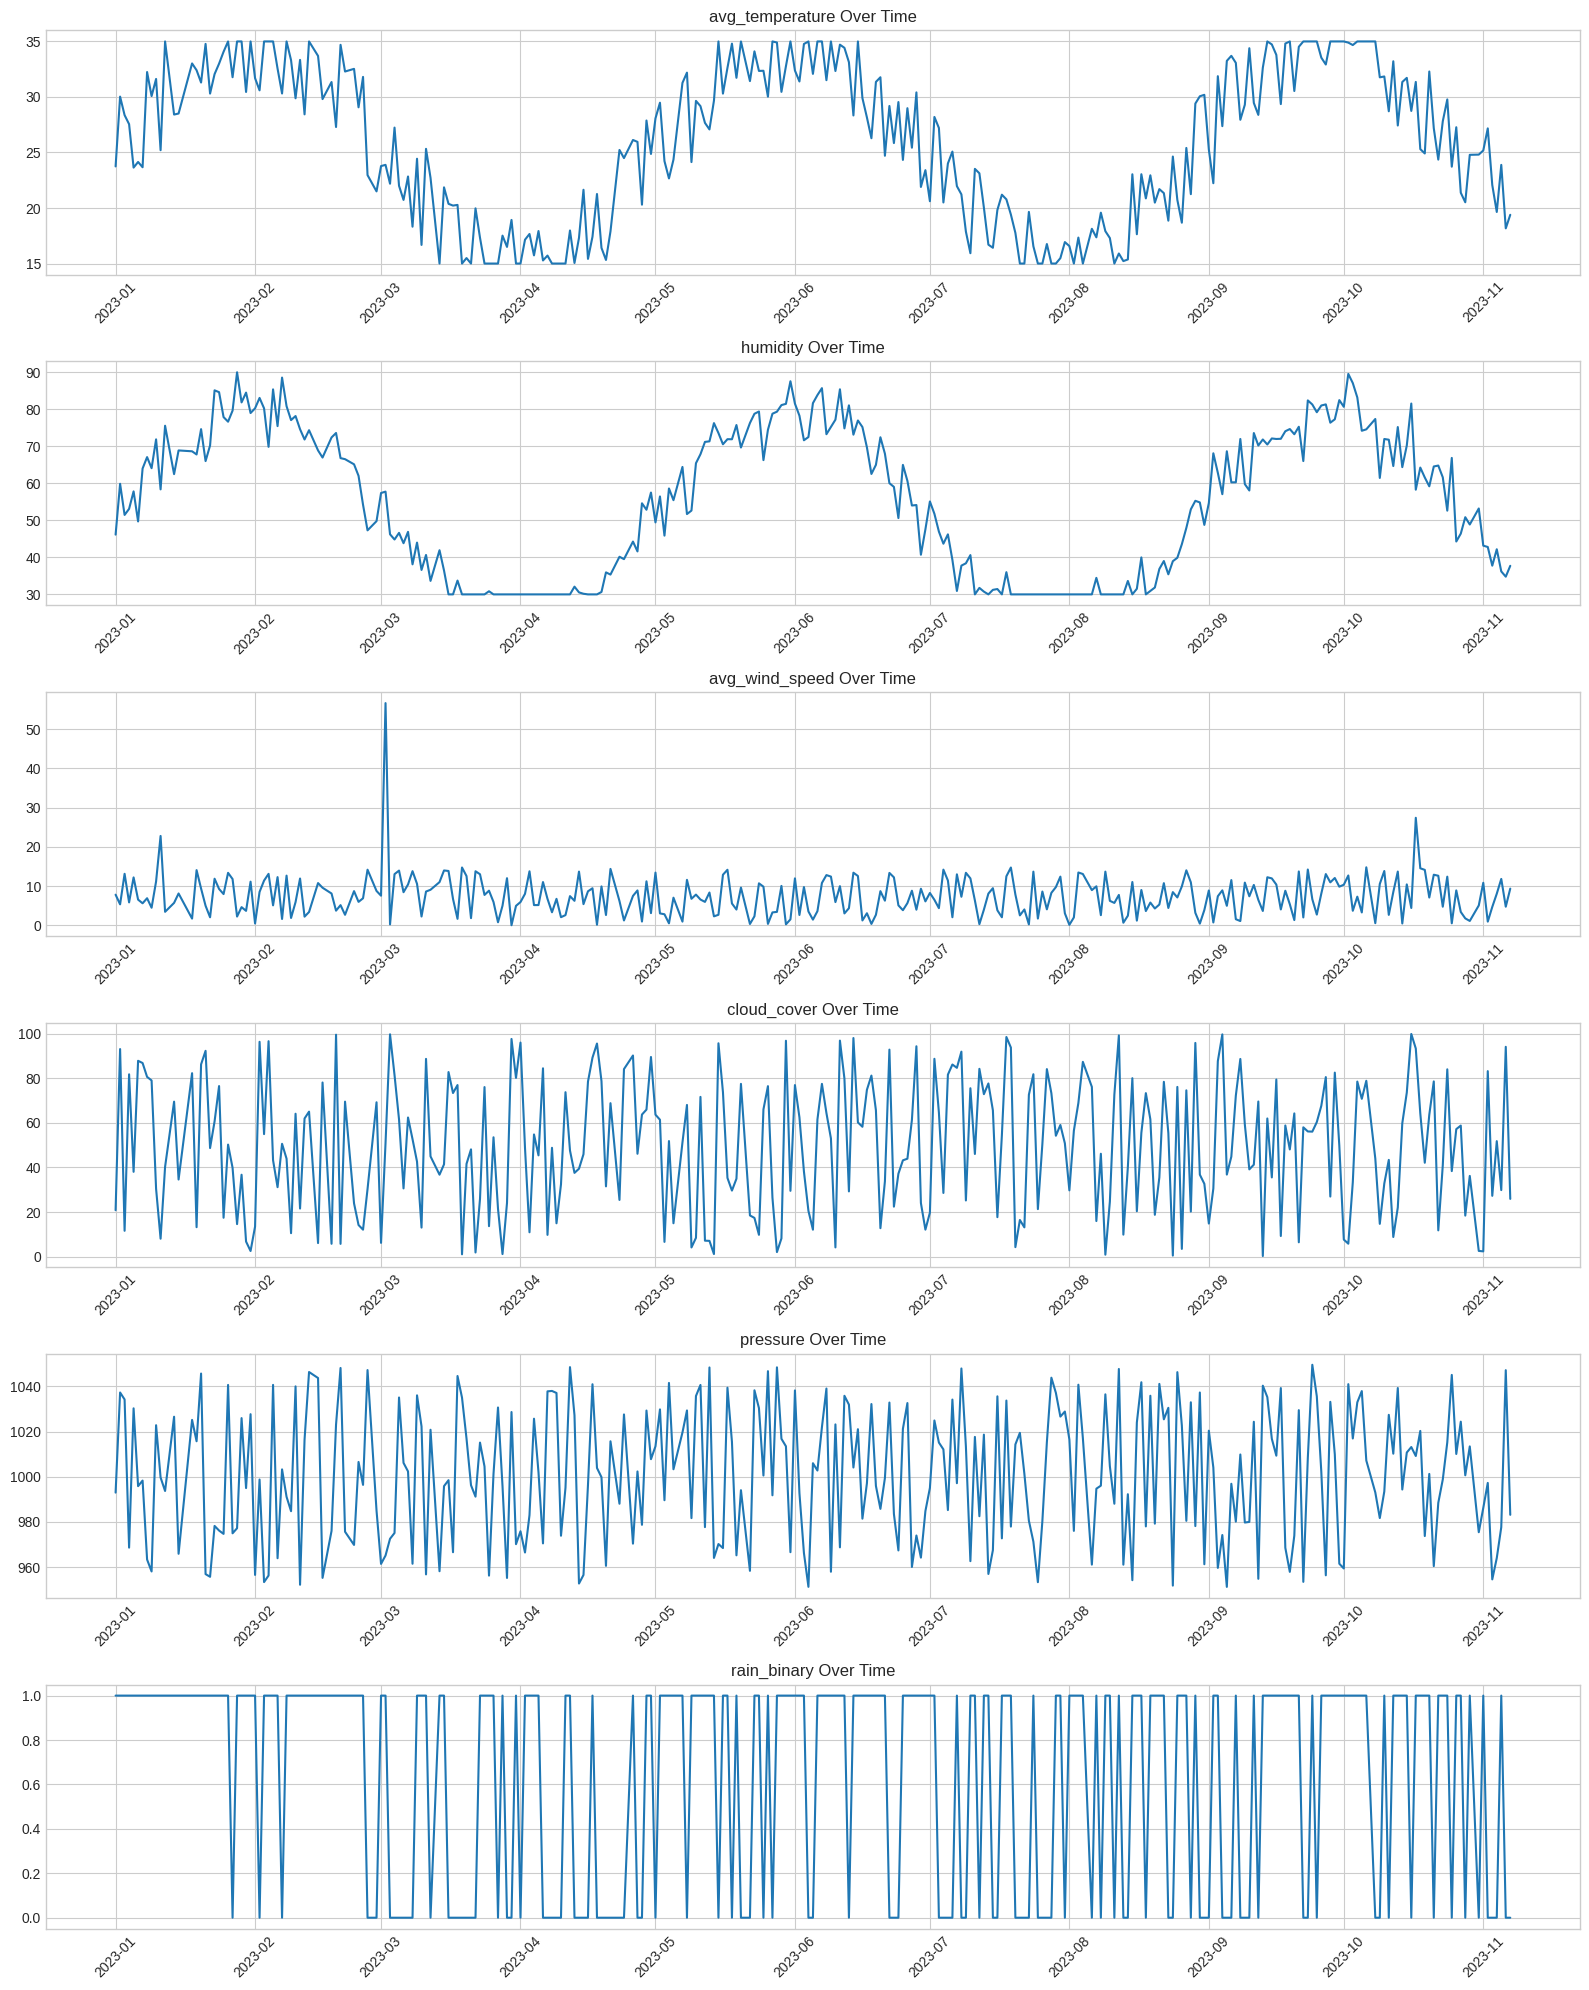

In [121]:
plt.figure(figsize=(16, 20))
features_to_plot = numerical_features + ['rain_binary']
for i, feature in enumerate(features_to_plot):
    plt.subplot(len(features_to_plot), 1, i+1)
    plt.plot(clean_data['date'], clean_data[feature])
    plt.title(f'{feature} Over Time')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

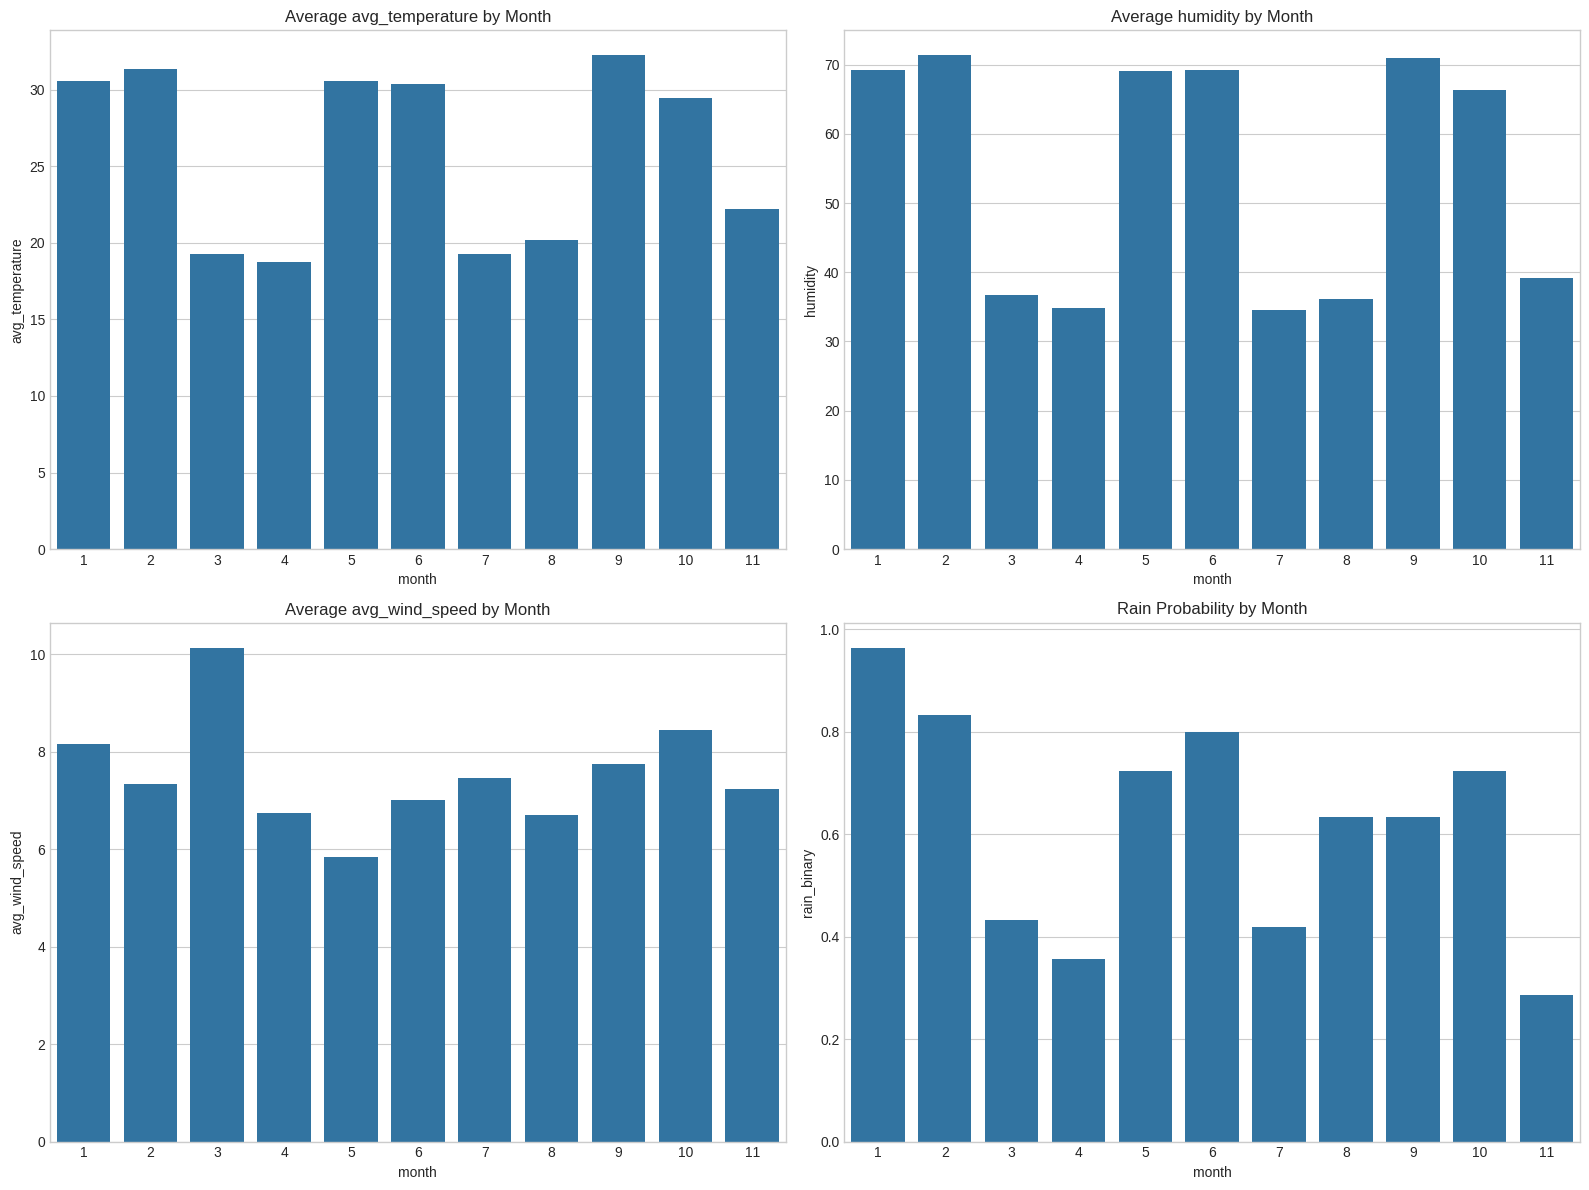

In [122]:
# Seasonal patterns: monthly averages
monthly_data = clean_data.groupby('month').agg({
    'avg_temperature': 'mean',
    'humidity': 'mean',
    'avg_wind_speed': 'mean',
    'rain_binary': 'mean'  # This gives us rain probability per month
}).reset_index()

plt.figure(figsize=(16, 12))
for i, feature in enumerate(numerical_features[:3]):  # First 3 features
    plt.subplot(2, 2, i+1)
    sns.barplot(x='month', y=feature, data=monthly_data)
    plt.title(f'Average {feature} by Month')

plt.subplot(2, 2, 4)
sns.barplot(x='month', y='rain_binary', data=monthly_data)
plt.title('Rain Probability by Month')
plt.tight_layout()
plt.show()

In [123]:
def engineer_features(data):
    # Create a copy of the dataframe
    df_features = data.copy()

    # Lag features for time series aspect (previous day's values)
    for feature in numerical_features:
        df_features[f'{feature}_lag1'] = df_features[feature].shift(1)
        df_features[f'{feature}_lag2'] = df_features[feature].shift(2)

    # Rolling window features (3-day and 7-day averages)
    for feature in numerical_features:
        df_features[f'{feature}_rolling3'] = df_features[feature].rolling(window=3).mean()
        df_features[f'{feature}_rolling7'] = df_features[feature].rolling(window=7).mean()

    # Exponentially weighted moving averages (EWMA)
    for feature in numerical_features:
        df_features[f'{feature}_ewma3'] = df_features[feature].ewm(span=3).mean()
        df_features[f'{feature}_ewma7'] = df_features[feature].ewm(span=7).mean()

    # Trend components (using difference between current value and previous)
    for feature in numerical_features:
        df_features[f'{feature}_trend'] = df_features[feature] - df_features[feature].shift(1)

    # Interaction features
    df_features['temp_humidity_ratio'] = df_features['avg_temperature'] / df_features['humidity']
    df_features['temp_wind_ratio'] = df_features['avg_temperature'] / df_features['avg_wind_speed']

    # Drop rows with NaN values created by lag and rolling features
    df_features = df_features.dropna()

    return df_features



In [124]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

def select_features(X, y, k=15):
    # Use SelectKBest with mutual_info_classif for time-series data
    selector = SelectKBest(mutual_info_classif, k=k)
    X_selected = selector.fit_transform(X, y)

    # Get selected feature names
    selected_indices = selector.get_support(indices=True)
    selected_features = X.columns[selected_indices].tolist()

    # Get feature scores
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    })
    feature_scores = feature_scores.sort_values('Score', ascending=False)

    return X_selected, selected_features, feature_scores


In [126]:
def check_feature_set(engineered_data, selected_features, k=15):
    feature_cols = [col for col in engineered_data.columns if col not in ['date', 'rain_or_not', 'rain_binary']]
    X = engineered_data[feature_cols]
    y = engineered_data['rain_binary']

    # Select the top k features based on feature scores
    X_selected, selected_features, feature_scores = select_features(X, y, k)

    print("Top 15 selected features:")
    display(feature_scores.head(15))

    return X_selected, selected_features, feature_scores


In [128]:
# Feature Engineering
engineered_data = engineer_features(clean_data)
print("Engineered data shape:", engineered_data.shape)
display(engineered_data.head())

# Checking Feature Set and Feature Selection
X_selected, selected_features, feature_scores = check_feature_set(engineered_data, selected_features, k=15)




Engineered data shape: (290, 47)


,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure,month,day_of_week,rain_binary,...,cloud_cover_ewma7,pressure_ewma3,pressure_ewma7,avg_temperature_trend,humidity_trend,avg_wind_speed_trend,cloud_cover_trend,pressure_trend,temp_humidity_ratio,temp_wind_ratio
6,2023-01-07,23.671006,63.997418,5.654166,Rain,86.805669,998.296887,1,5,1,...,68.673382,1001.532239,1005.006858,-0.477130,14.293983,-0.932857,-0.991763,2.478199,0.369874,4.186471
7,2023-01-08,32.245441,67.083073,6.940197,Rain,80.592540,963.347997,1,6,1,...,71.984675,982.365247,993.433500,8.574435,3.085654,1.286030,-6.213129,-34.948890,0.480679,4.646185
8,2023-01-09,30.078517,64.088581,4.520668,Rain,79.003044,958.060151,1,0,1,...,73.881705,970.188917,983.872260,-2.166924,-2.994492,-2.419529,-1.589496,-5.287846,0.469327,6.653556
9,2023-01-10,31.620631,71.876470,11.214141,Rain,30.467914,1022.793931,1,1,1,...,62.380589,996.517135,994.183330,1.542114,7.787889,6.693473,-48.535130,64.733779,0.439930,2.819711
10,2023-01-11,25.205845,58.365841,22.803513,Rain,8.091928,999.646115,1,2,1,...,48.209924,998.082390,995.609251,-6.414786,-13.510629,11.589373,-22.375986,-23.147815,0.431860,1.105349


Top 15 selected features:


,Feature,Score
10,humidity_lag2,0.124955
18,avg_temperature_rolling7,0.122704
5,month,0.110493
28,avg_temperature_ewma7,0.091158
17,avg_temperature_rolling3,0.069097
32,avg_wind_speed_ewma7,0.067995
30,humidity_ewma7,0.059283
9,humidity_lag1,0.052261
29,humidity_ewma3,0.050505
20,humidity_rolling7,0.047765


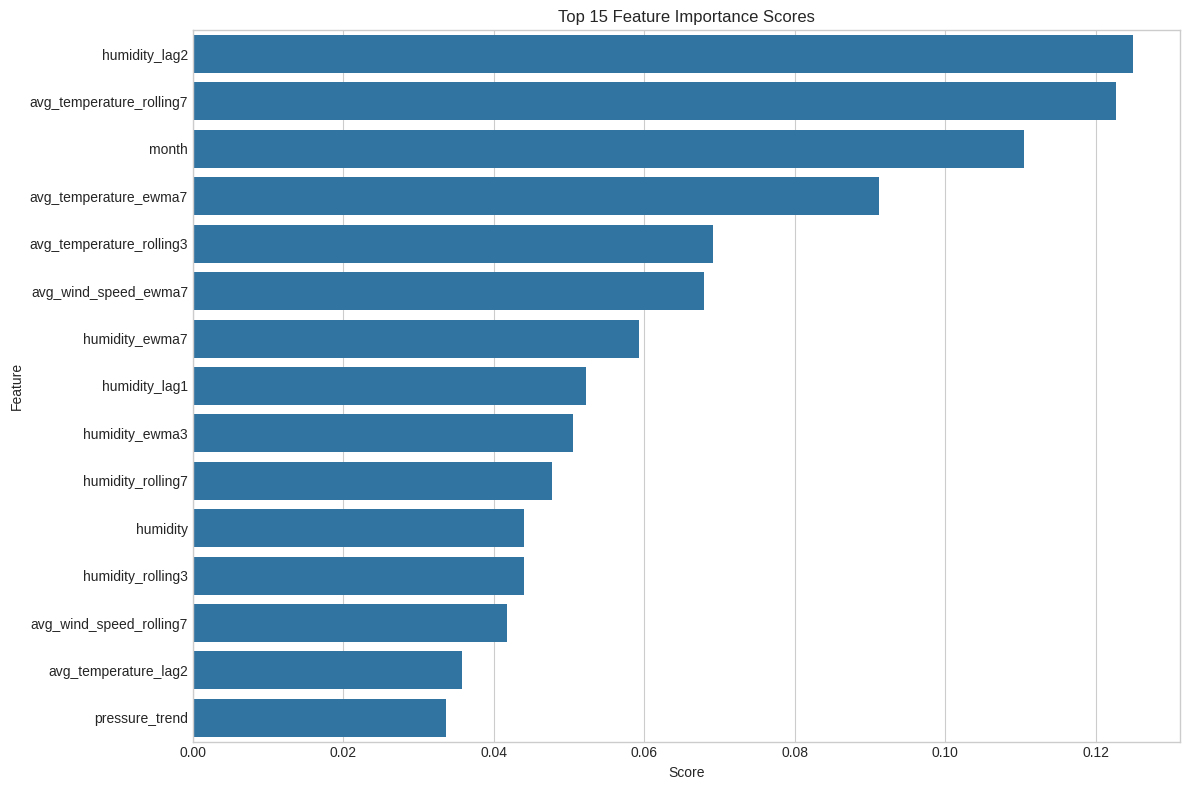

In [129]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores.head(15))
plt.title('Top 15 Feature Importance Scores')
plt.tight_layout()
plt.show()

In [130]:
X_final = engineered_data[selected_features]
print("Final feature set shape:", X_final.shape)

Final feature set shape: (290, 15)


In [131]:
# Model Training and Evaluation
train_size = int(len(X_final) * 0.8)
X_train, X_test = X_final[:train_size], X_final[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability for class 1 (Rain)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Return the model and metrics
    return model, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
    }

Training set: (232, 15), Testing set: (58, 15)



Logistic Regression Results:
Accuracy: 0.6724
Precision: 0.7174
Recall: 0.8462
F1 Score: 0.7765
ROC AUC Score: 0.5722

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.32      0.39        19
           1       0.72      0.85      0.78        39

    accuracy                           0.67        58
   macro avg       0.61      0.58      0.58        58
weighted avg       0.65      0.67      0.65        58



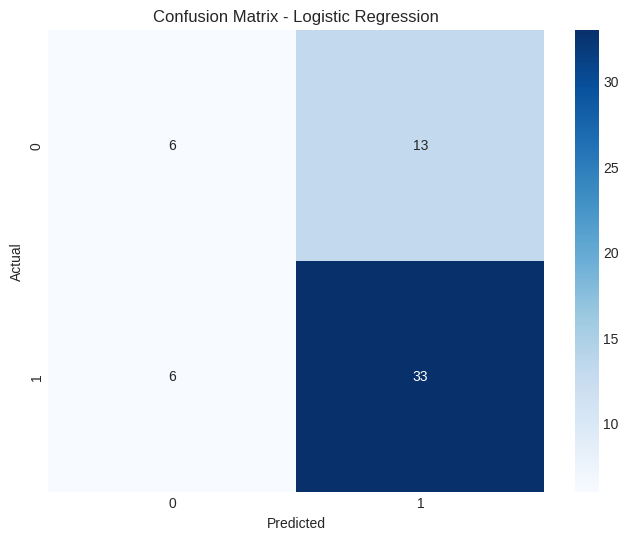


Decision Tree Results:
Accuracy: 0.3276
Precision: 0.5000
Recall: 0.1538
F1 Score: 0.2353
ROC AUC Score: 0.4190

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.68      0.40        19
           1       0.50      0.15      0.24        39

    accuracy                           0.33        58
   macro avg       0.39      0.42      0.32        58
weighted avg       0.43      0.33      0.29        58



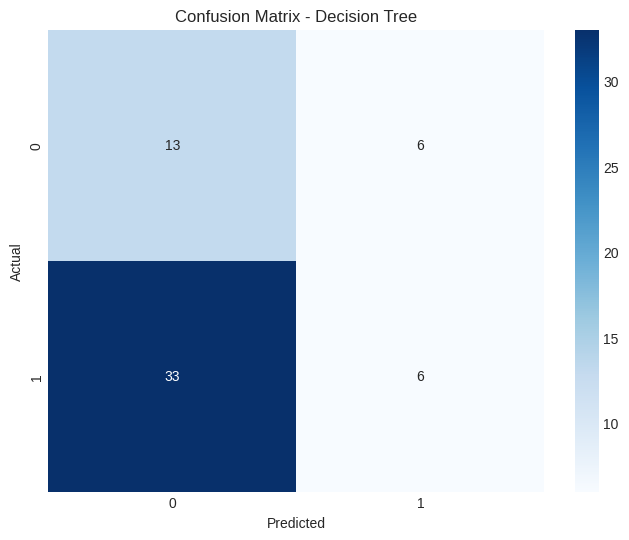


Random Forest Results:
Accuracy: 0.6897
Precision: 0.7059
Recall: 0.9231
F1 Score: 0.8000
ROC AUC Score: 0.6545

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.21      0.31        19
           1       0.71      0.92      0.80        39

    accuracy                           0.69        58
   macro avg       0.64      0.57      0.55        58
weighted avg       0.66      0.69      0.64        58



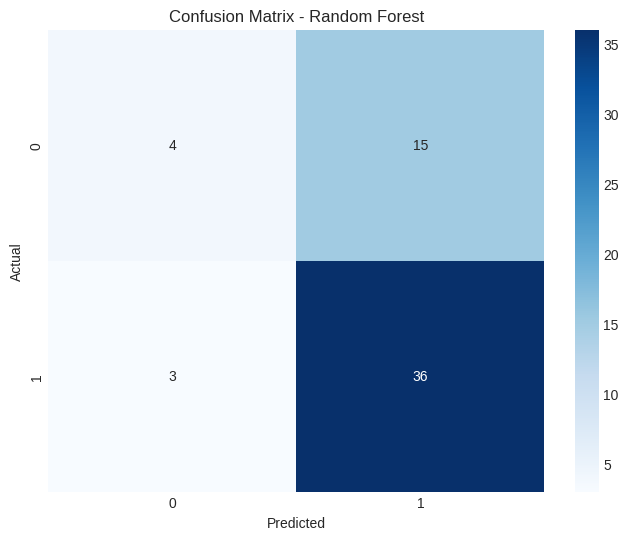


Gradient Boosting Results:
Accuracy: 0.3966
Precision: 0.6250
Recall: 0.2564
F1 Score: 0.3636
ROC AUC Score: 0.4777

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.68      0.43        19
           1       0.62      0.26      0.36        39

    accuracy                           0.40        58
   macro avg       0.47      0.47      0.39        58
weighted avg       0.52      0.40      0.38        58



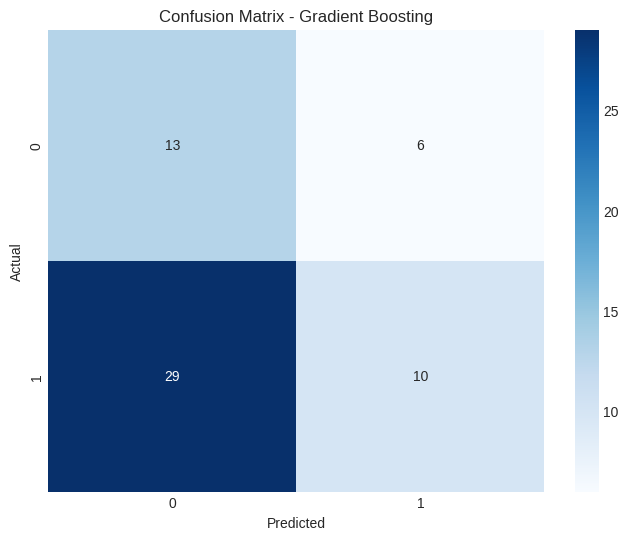

<Figure size 1200x800 with 0 Axes>

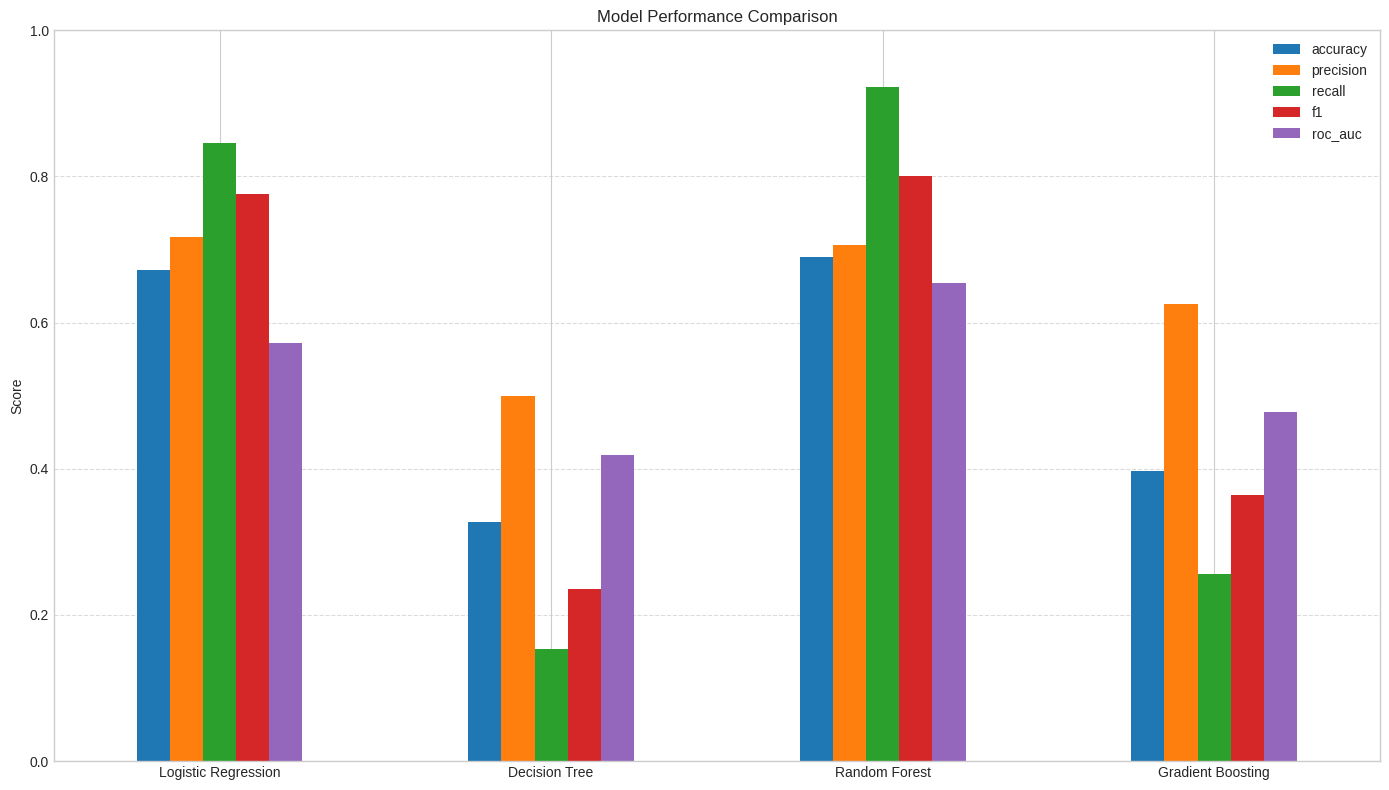

In [132]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

model_results = {}


for name, model in models.items():
    trained_model, metrics = train_and_evaluate_model(
        model, X_train_scaled, y_train, X_test_scaled, y_test, name
    )
    model_results[name] = {
        'model': trained_model,
        'metrics': metrics
    }

# Compare model performance
metrics_df = pd.DataFrame({
    model_name: results['metrics']
    for model_name, results in model_results.items()
})

plt.figure(figsize=(12, 8))
metrics_df.T.plot(kind='bar', rot=0)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [133]:
best_model_name = metrics_df.loc['f1'].idxmax()
print(f"\nBest performing model based on F1 score: {best_model_name}")


Best performing model based on F1 score: Random Forest


In [134]:
param_grids = {
    'Logistic Regression': {
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'max_depth': [5, 10, 15, 20, 30, 40, None],
        'min_samples_split': [2, 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4, 6, 8]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, 50, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7, 9, 12]
    }
}


Fitting 5 folds for each of 320 candidates, totalling 1600 fits

Best parameters for Random Forest:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Random Forest (Tuned) Results:
Accuracy: 0.6552
Precision: 0.6863
Recall: 0.8974
F1 Score: 0.7778
ROC AUC Score: 0.6869

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.16      0.23        19
           1       0.69      0.90      0.78        39

    accuracy                           0.66        58
   macro avg       0.56      0.53      0.50        58
weighted avg       0.60      0.66      0.60        58



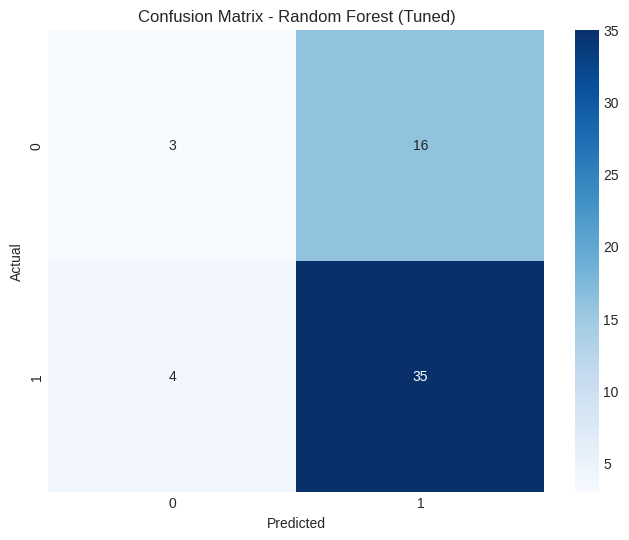


Baseline vs Tuned Model Comparison:


,accuracy,precision,recall,f1,roc_auc
Baseline,0.689655,0.705882,0.923077,0.800000,0.654521
Tuned,0.655172,0.686275,0.897436,0.777778,0.686910


In [142]:
best_model = models[best_model_name]
param_grid = param_grids[best_model_name]

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='balanced_accuracy',  # Changed to balanced accuracy
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
print(f"\nBest parameters for {best_model_name}:")
print(best_params)

# Evaluate the tuned model
best_tuned_model = grid_search.best_estimator_
tuned_model, tuned_metrics = train_and_evaluate_model(
    best_tuned_model, X_train_scaled, y_train, X_test_scaled, y_test,
    f"{best_model_name} (Tuned)"
)

# Compare baseline vs tuned model
print("\nBaseline vs Tuned Model Comparison:")
baseline_metrics = model_results[best_model_name]['metrics']
comparison_df = pd.DataFrame({
    'Baseline': baseline_metrics,
    'Tuned': tuned_metrics
})
display(comparison_df.T)




Rain probability predictions for the next 21 days:


,date,month,day_of_week,rain_probability
0,2023-11-08,11,2,0.725405
1,2023-11-09,11,3,0.725405
2,2023-11-10,11,4,0.725405
3,2023-11-11,11,5,0.725405
4,2023-11-12,11,6,0.725405
5,2023-11-13,11,0,0.725405
6,2023-11-14,11,1,0.725405
7,2023-11-15,11,2,0.725405
8,2023-11-16,11,3,0.725405
9,2023-11-17,11,4,0.725405


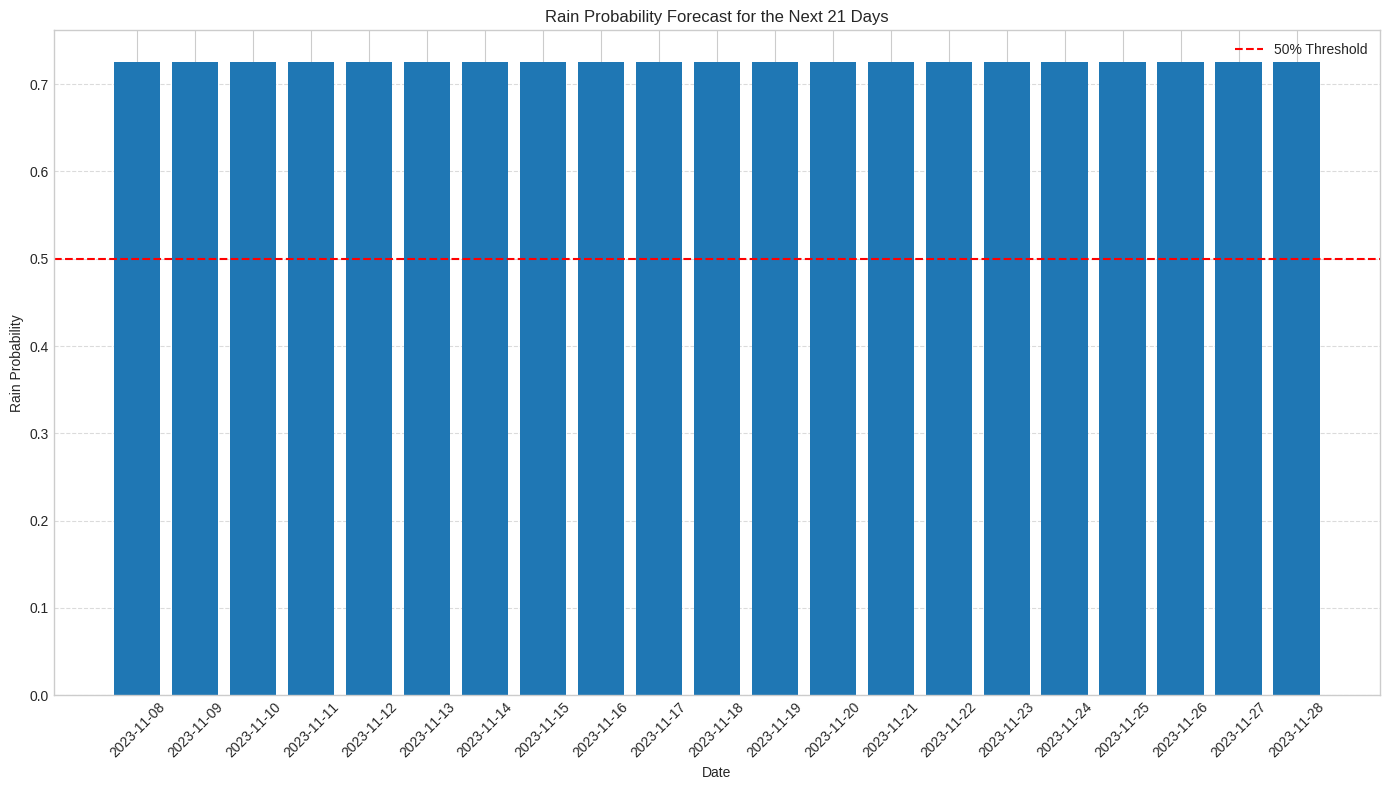

In [146]:
best_model = tuned_model
with open('rain_prediction_model.pkl', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'scaler': scaler,
        'features': selected_features
    }, f)

# Function to predict rain probability for future days
def predict_rain_probability(data, days=21):
    """
    Predict rain probability for future days based on historical data

    Parameters:
    -----------
    data : DataFrame
        Historical weather data
    days : int
        Number of future days to predict

    Returns:
    --------
    DataFrame with dates and rain probabilities
    """
    # Get the last date in the dataset
    last_date = pd.to_datetime(data['date'].max())

    # Create future dates
    future_dates = [last_date + pd.Timedelta(days=i+1) for i in range(days)]

    future_predictions = []

    # For each future date, calculate predictions based on the latest historical data
    for future_date in future_dates:
        # Get the month and day of the week
        month = future_date.month
        day_of_week = future_date.dayofweek

        # Filter for the latest historical data (near to the future date)
        recent_data = data[data['date'] <= future_date].tail(30)  # Use the last 30 days for prediction

        if len(recent_data) > 0:
            # Get feature values for the most recent data
            feature_values = {}
            for feature in selected_features:
                if feature in recent_data.columns:
                    feature_values[feature] = recent_data[feature].iloc[-1]
                elif '_lag' in feature:
                    # For lag features, use the most recent value
                    base_feature = feature.split('_lag')[0]
                    if base_feature in recent_data.columns:
                        feature_values[feature] = recent_data[base_feature].iloc[-1]
                    else:
                        feature_values[feature] = 0
                elif '_rolling' in feature:
                    # For rolling features, use the rolling average of the last 7 days
                    base_feature = feature.split('_rolling')[0]
                    if base_feature in recent_data.columns:
                        feature_values[feature] = recent_data[base_feature].rolling(window=7).mean().iloc[-1]
                    else:
                        feature_values[feature] = 0
                else:
                    # Handle derived features
                    if feature == 'temp_humidity_ratio' and 'avg_temperature' in recent_data.columns and 'humidity' in recent_data.columns:
                        feature_values[feature] = recent_data['avg_temperature'].iloc[-1] / recent_data['humidity'].iloc[-1]
                    elif feature == 'temp_wind_ratio' and 'avg_temperature' in recent_data.columns and 'avg_wind_speed' in recent_data.columns:
                        feature_values[feature] = recent_data['avg_temperature'].iloc[-1] / recent_data['avg_wind_speed'].iloc[-1]
                    else:
                        feature_values[feature] = 0  # Fallback

            # Scale the features
            features_scaled = scaler.transform([list(feature_values.values())])

            # Predict the rain probability using the trained model
            rain_prob = best_model.predict_proba(features_scaled)[0, 1]

            future_predictions.append({
                'date': future_date,
                'month': month,
                'day_of_week': day_of_week,
                'rain_probability': rain_prob
            })
        else:
            # If no recent data is available, use a default probability (50%)
            future_predictions.append({
                'date': future_date,
                'month': month,
                'day_of_week': day_of_week,
                'rain_probability': 0.5
            })

    return pd.DataFrame(future_predictions)

# Predict rain probability for the next 21 days
future_predictions = predict_rain_probability(engineered_data, days=21)

# Display the predictions
print("\nRain probability predictions for the next 21 days:")
display(future_predictions)

# Plot rain probabilities for future days
plt.figure(figsize=(14, 8))
plt.bar(future_predictions['date'].astype(str), future_predictions['rain_probability'])
plt.axhline(y=0.5, color='r', linestyle='--', label='50% Threshold')
plt.title('Rain Probability Forecast for the Next 21 Days')
plt.xlabel('Date')
plt.ylabel('Rain Probability')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()
plt.show()



Time Series Cross-Validation Results:
accuracy: Mean = 0.5842, Std = 0.1325
precision: Mean = 0.6121, Std = 0.1217
recall: Mean = 0.7248, Std = 0.3154
f1: Mean = 0.6203, Std = 0.1708
roc_auc: Mean = 0.5418, Std = 0.1428


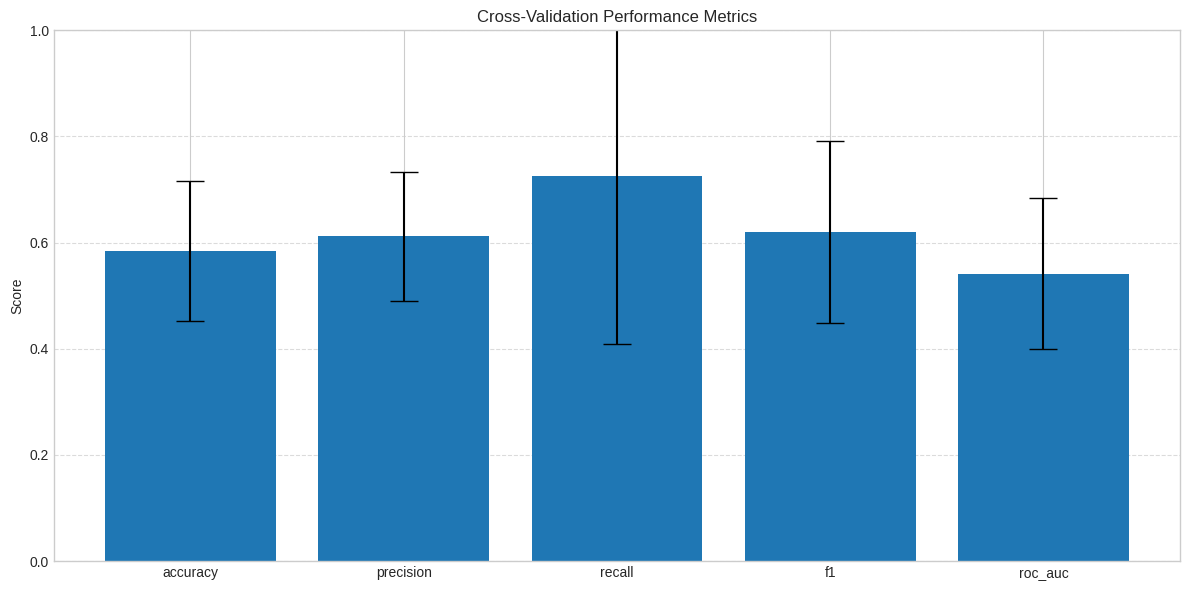

In [144]:
def time_series_cv_evaluation(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': []
    }

    for train_idx, test_idx in tscv.split(X):
        X_train_cv, X_test_cv = X[train_idx], X[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]

        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)
        y_pred_proba = model.predict_proba(X_test_cv)[:, 1]

        cv_scores['accuracy'].append(accuracy_score(y_test_cv, y_pred))
        cv_scores['precision'].append(precision_score(y_test_cv, y_pred))
        cv_scores['recall'].append(recall_score(y_test_cv, y_pred))
        cv_scores['f1'].append(f1_score(y_test_cv, y_pred))
        cv_scores['roc_auc'].append(roc_auc_score(y_test_cv, y_pred_proba))

    # Calculate mean and std for each metric
    cv_results = {metric: {'mean': np.mean(scores), 'std': np.std(scores)}
                  for metric, scores in cv_scores.items()}

    return cv_results

# Convert to numpy arrays for cross-validation
X_array = X_train_scaled
y_array = np.array(y_train)

# Evaluate best model with time series cross-validation
cv_results = time_series_cv_evaluation(best_model, X_array, y_array)

print("\nTime Series Cross-Validation Results:")
for metric, values in cv_results.items():
    print(f"{metric}: Mean = {values['mean']:.4f}, Std = {values['std']:.4f}")

# Plot CV results
plt.figure(figsize=(12, 6))
metrics = list(cv_results.keys())
means = [cv_results[metric]['mean'] for metric in metrics]
stds = [cv_results[metric]['std'] for metric in metrics]

plt.bar(metrics, means, yerr=stds, capsize=10)
plt.title('Cross-Validation Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Feature Importance for the Final Model:


,Feature,Importance
11,humidity_ewma3,0.111358
0,humidity,0.102357
12,humidity_ewma7,0.093851
6,avg_temperature_rolling7,0.093246
8,humidity_rolling7,0.074969
14,pressure_trend,0.070887
2,avg_temperature_lag2,0.062773
7,humidity_rolling3,0.061799
5,avg_temperature_rolling3,0.060242
10,avg_temperature_ewma7,0.059633


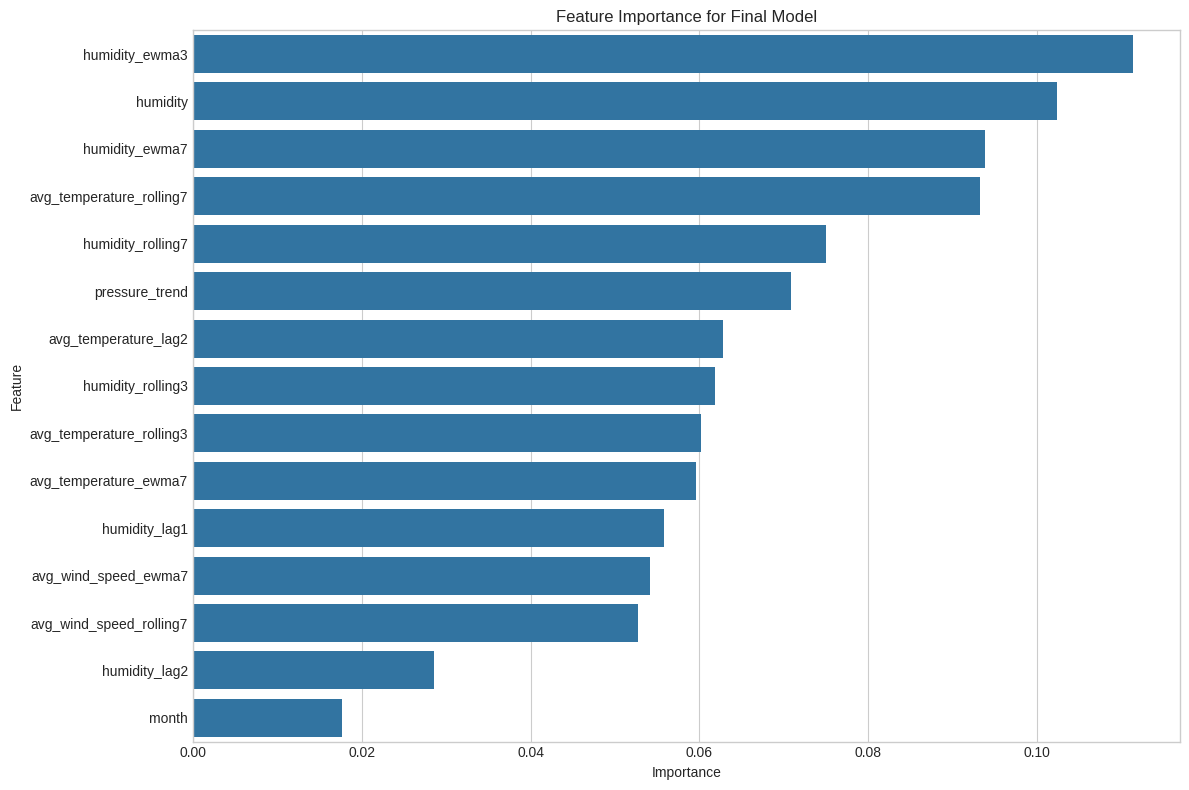


========== MODEL SUMMARY ==========
Best Model: Random Forest with tuned parameters
Number of features used: 15
Test Set Performance: Accuracy = 0.6552, F1 Score = 0.7778
Cross-Validation F1 Score: 0.6203 ± 0.1708

Predictions saved to 'rain_predictions_next_21_days.csv'


In [145]:
if hasattr(best_model, 'feature_importances_'):
    # For tree-based models
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
elif hasattr(best_model, 'coef_'):
    # For linear models
    importances = np.abs(best_model.coef_[0])
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
else:
    feature_importance = pd.DataFrame()

if not feature_importance.empty:
    print("\nFeature Importance for the Final Model:")
    display(feature_importance)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance for Final Model')
    plt.tight_layout()
    plt.show()

# Print final summary
print("\n========== MODEL SUMMARY ==========")
print(f"Best Model: {best_model_name} with tuned parameters")
print(f"Number of features used: {len(selected_features)}")
print(f"Test Set Performance: Accuracy = {tuned_metrics['accuracy']:.4f}, F1 Score = {tuned_metrics['f1']:.4f}")
print(f"Cross-Validation F1 Score: {cv_results['f1']['mean']:.4f} ± {cv_results['f1']['std']:.4f}")
print("==================================")

# Save the predictions to CSV
future_predictions.to_csv('rain_predictions_next_21_days.csv', index=False)
print("\nPredictions saved to 'rain_predictions_next_21_days.csv'")